In [337]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Libraries for ROC plots
from scipy import interp
from sklearn.metrics import roc_curve, auc

# Libraries for Cross Validation
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

# Libraries for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [338]:
# Function for fixing the missing values in a feature meatrix (by replacing them for the mean)
def fixMissingValues(array):
    
    arr = np.copy(array)
    means = []
    sumv = 0
    count = 0
    
    for j in range(len(arr[0])):
        for i in range(len(arr)):
            if arr[i][j] == -1:
                continue
            else:
                sumv = sumv + int(arr[i][j])
                count = count + 1  
        means.append(int(1.0*sumv/count))
        sumv = 0
        count = 0

    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if arr[i][j] == -1:
                arr[i][j] = means[j]
            else:
                arr[i][j] = int(arr[i][j])
    
    return arr

In [339]:
# Get the data from a .csv
snpscsv = pd.read_csv('snpsobes.csv')
snps = snpscsv.values
Xpp = snps[:, 1:-1]
Y = snps[:, -1]

# Fix missing values and create design matrix
Xp = fixMissingValues(Xpp)
Xp = np.column_stack((np.ones(Xp.shape[0]), Xp))

In [340]:
# One-Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Xp)
X = enc.transform(Xp).toarray()
feature_names = enc.get_feature_names()

# Gather all the data in a single matrix
snpdata = np.column_stack((X, Y))
snpdata.shape

(565, 1044)

In [463]:
# Perform a 5-fold cross validation for several polynomial degrees, and plot the ROCs
def run_cv(data, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(data):
        train = []
        test = []
        for index in train_index:
            train.append(list(data[index]))
        train = np.array(train)
        for index in test_index:
            test.append(list(data[index]))
        test = np.array(test)
        Xt = train[:, :-1]
        Yt = train[:, -1]
        Xv = test[:, :-1]
        Yv = test[:, -1]
        lr.fit(Xt, Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(Xv)
        Yprob = lr.predict_proba(Xv)
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

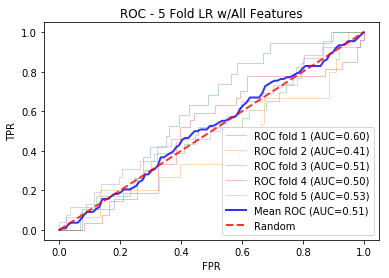

In [464]:
run_cv(snpdata, 5, "ROC - 5 Fold LR w/All Features")

In [426]:
# Variable selection
def selectVariables(coef, threshold):

    k = 0
    f = 0
    features = []
    for i in coef[0]:
        if abs(i) > threshold:
            features.append(feature_names[k])
            f = f + 1
        k = k + 1

    snpsnamescsv = pd.read_csv('snpsobes.csv', header=None)
    selected_snps = []
    
    for feature in features:
        selected_snps.append(snpsnamescsv.iloc[0][int(feature.split("_")[0].split("x")[1])])

    # Create new features matrix
    i = 0
    selected_data = []
    for snp in selected_snps:
        if i == 0:
            selected_data = snpscsv.iloc[:][snp]
        else:
            selected_data = np.column_stack((selected_data, snpscsv.iloc[:][snp]))
        i = i + 1
    selected_data = np.column_stack((selected_data, snpscsv.iloc[:]['Obesidad']))
    
    return selected_data

In [427]:
def runMultipleModels(X, Y, n, min_threshold):
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    lr.fit(X, Y)
    for i in range(0, n):
        current_threshold = min_threshold*pow(10, i)
        # Create design matrix
        selected_data = selectVariables(lr.coef_, current_threshold)
        phi_data = np.column_stack((np.ones(snpscsv.shape[0]), selected_data))
        name = "ROC - 5 Fold LR w/" + str(selected_data.shape[1]) + " features"
        run_cv(phi_data, 5, name)
        i = i*pow(10, 2)

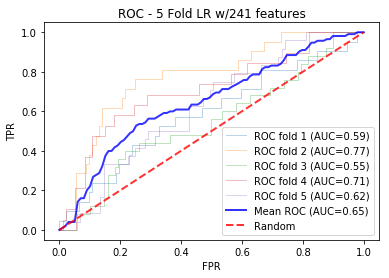

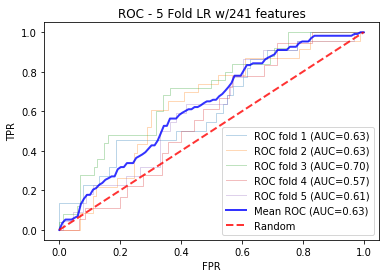

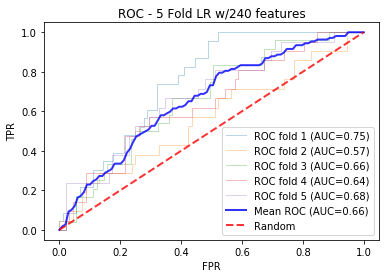

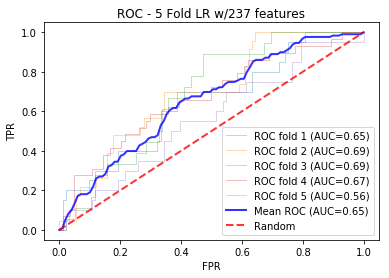

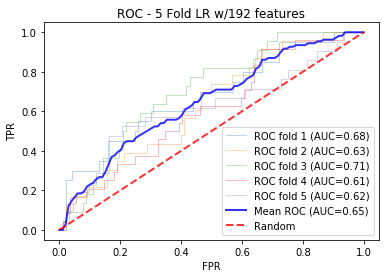

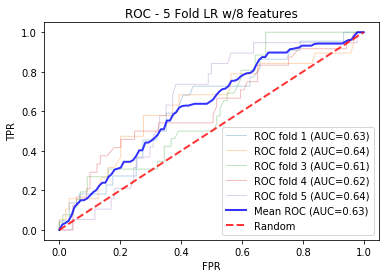

In [428]:
runMultipleModels(X, Y, 6, 0.00001)